In [1]:
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [2]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay


def show_videos(video_path="", prefix=""):
    """
    Taken from https://github.com/eleurent/highway-env

    :param video_path: (str) Path to the folder containing videos
    :param prefix: (str) Filter the video, showing only the only starting with this prefix
    """
    html = []
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            """<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>""".format(
                mp4, video_b64.decode("ascii")
            )
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [3]:
import gymnasium as gym
import numpy as np
import tempfile
import os

from stable_baselines3.common.results_plotter import load_results, ts2xy          # import funkci na vyzobrazenie vysledkov
from stable_baselines3.common.noise import NormalActionNoise                      # import dacoho
from stable_baselines3.common.callbacks import BaseCallback                       # import callback funkcie
from stable_baselines3.common.monitor import Monitor                              # na zobrazenie treningoveho progresu
from stable_baselines3.common.callbacks import CheckpointCallback                 # callback pocas treningu
from stable_baselines3 import DQN                                                 # import DQN algoritmu
from stable_baselines3 import SAC                                                 # import SAC algoritmu
from stable_baselines3 import A2C        

from stable_baselines3 import PPO            
from stable_baselines3.common.env_util import make_vec_env          

In [4]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

# **3. Vytvorenie Gym prostredia a iniciacia agenta**

Pre LunarLander sme si vybrali DQN algoritmus s MLP taktiku pretoze nase prostredie ma vektory a nie obrazky, mozeme to vsak zmenit na SAC alebo A2C algoritmus

In [5]:
log_dir = 'rl/gym'
os.makedirs(log_dir, exist_ok=True)          # docasny priecinok na ukladanie progresu treningu

env = gym.make('CarRacing-v2', continuous=False, domain_randomize=False)           # vytvorenie prostredia LunarLander(da sa zmenit na iné napr CarRacing-v2)
env = Monitor(env, log_dir)                  # pridanie triedy Monitor do prostredia a virtualneho priecinku, tu sa ukladaju logy 

model = PPO(                      # mozeme zmenit na SAC alebo A2C
    "CnnPolicy",                  # typ neuronovej siete
    env,                          # typ prostredia
    verbose=1,                    # print progresu do konzoly
    # exploration_final_eps=0.1,   # finalna hodnota šance nahodnych akcii namiesto doporučených akcií 
    # target_update_interval=250,  # frekvencia updatu neuronovej siete
    # learning_rate = 0.001,          # rýchlosť učenia v intervale <0,1>
    # buffer_size = 1000,           # veľkosť buffera na ukladanie skúseností
    batch_size = 256 ,
                          # veľkosť vzorky ktorá sa načíta z buffera

)                                  
"""
Tieto zakomentovane hyperparametre nemusíme nastavovať pretože sa nastavia automaticky, no možeme ručne menit ich hodnoty
"""



Using cuda device
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


'\nTieto zakomentovane hyperparametre nemusíme nastavovať pretože sa nastavia automaticky, no možeme ručne menit ich hodnoty\n'

Nacitame si pomocnu funkciu, ktora bude hodnotit agenta bez treningu v prostredi

In [6]:
from stable_baselines3.common.evaluation import evaluate_policy

Zhodnotime vykon agenta bez treningu v prostredi

In [7]:
# Separacia prostredia na evaluaciu
eval_env = gym.make("CarRacing-v2", continuous=False, domain_randomize=False)

# Nahodny agent bez treningu
mean_reward, std_reward = evaluate_policy(
    model,
    eval_env,
    n_eval_episodes=10,
    deterministic=True,
)
# Vypis AVERAGE odmeny agenta bez treningu
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

c:\Users\marti\miniconda3\envs\win-torch\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward=-91.42 +/- 5.171379294273662


Nahrame agenta bez treningu do videa 

In [8]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv


def record_video(env_id, model, video_length=500, prefix="", video_folder="rl/videos/"):
    """
    :param env_id: (str)
    :param model: (RL model)
    :param video_length: (int)
    :param prefix: (str)
    :param video_folder: (str)
    """
    eval_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array", continuous=False, domain_randomize=False)])
    # Start the video at step=0 and record 500 steps
    eval_env = VecVideoRecorder(
        eval_env,
        video_folder=video_folder,
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=prefix,
    )

    obs = eval_env.reset()
    for _ in range(video_length):
        action, _ = model.predict(obs)
        obs, _, _, _ = eval_env.step(action)

   
    eval_env.close()

In [9]:
record_video("CarRacing-v2", model, video_length=600, prefix="noTraining-CarRacing-v2")

Saving video to c:\FEI\HNS\hns-bl\rl\videos\noTraining-CarRacing-v2-step-0-to-step-600.mp4
Moviepy - Building video c:\FEI\HNS\hns-bl\rl\videos\noTraining-CarRacing-v2-step-0-to-step-600.mp4.
Moviepy - Writing video c:\FEI\HNS\hns-bl\rl\videos\noTraining-CarRacing-v2-step-0-to-step-600.mp4



Moviepy - Done !
Moviepy - video ready c:\FEI\HNS\hns-bl\rl\videos\noTraining-CarRacing-v2-step-0-to-step-600.mp4


In [10]:
show_videos("videos", prefix="noTraining")

# **4. Tréning agenta**

In [12]:
import matplotlib.pyplot as plt
import pandas as pd 

callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

# Trening, trva dlhsie 
model.learn(total_timesteps=int(1e5),callback=callback)


KeyboardInterrupt: 

In [13]:

# ulozime agenta ako dqn_lunar 
model.save("rl/sac_racing")


In [ ]:

# Vymazeme aby sme mohli loadovat neskor
del model  


Vykreslenie vysledkov učenia

In [20]:
def moving_average(values, window):
    """
    Uhladenie hodnot
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "same")

def plot_results( log_folder, title="Learning progress"):
    
    x1, y1 = ts2xy(load_results(log_dir), "timesteps")
    y1 = moving_average(y1, window=50)
    x1 = x1[len(x1) - len(y1) :]

    plt.plot(x1, y1, color='blue')
    plt.xlabel("Timesteps")
    plt.ylabel("Rewards")
    plt.show()

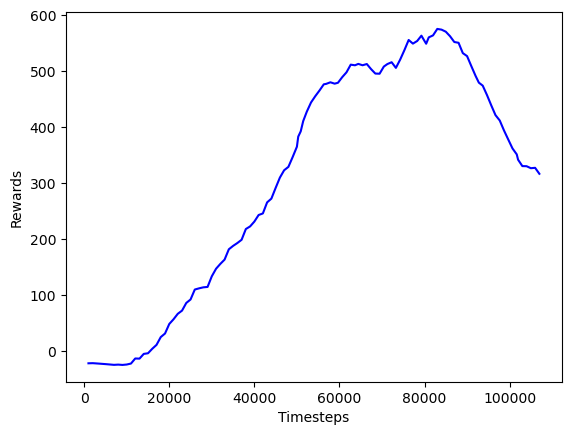

In [21]:
plot_results(log_dir)

# **5. Načítanie agenta**

Mozeme pridat dalsich inak natrenovanych agentov

In [17]:
model = PPO.load("rl/sac_racing")

Evaluacia natrenovaneho agenta

In [18]:
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)

print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

c:\Users\marti\miniconda3\envs\win-torch\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward=768.79 +/- 146.10048276844245


Nahrame video natrenovaneho agenta

In [22]:
def record_video(env_id, model, video_length=600, prefix="", video_folder="rl/videos/"):
    """
    :param env_id: (str)
    :param model: (RL model)
    :param video_length: (int)
    :param prefix: (str)
    :param video_folder: (str)
    """
    eval_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array", continuous=False, domain_randomize=False)])
    # Start the video at step=0 and record 500 steps
    eval_env = VecVideoRecorder(
        eval_env,
        video_folder=video_folder,
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=prefix,
    )

    obs = eval_env.reset()
    for _ in range(video_length):
        action, _ = model.predict(obs)
        obs, _, _, _ = eval_env.step(action)

    # Close the video recorder
    eval_env.close()

In [23]:
record_video("CarRacing-v2", model, video_length=700, prefix="sac-CarRacing-v2")

Saving video to c:\FEI\HNS\hns-bl\rl\videos\sac-CarRacing-v2-step-0-to-step-700.mp4
Moviepy - Building video c:\FEI\HNS\hns-bl\rl\videos\sac-CarRacing-v2-step-0-to-step-700.mp4.
Moviepy - Writing video c:\FEI\HNS\hns-bl\rl\videos\sac-CarRacing-v2-step-0-to-step-700.mp4



Moviepy - Done !
Moviepy - video ready c:\FEI\HNS\hns-bl\rl\videos\sac-CarRacing-v2-step-0-to-step-700.mp4


In [24]:
show_videos("rl/videos", prefix="sac")